In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib as mpl
import geopandas as gpd
from coord_convert.transform import wgs2gcj, wgs2bd, gcj2wgs, gcj2bd, bd2wgs, bd2gcj 
from shapely.geometry import Point,Polygon,shape
import shapely.geometry
import sys
sys.path.append(r'./packages_rely/')
import plot_map
import json
import osmnx as ox
from scipy.spatial.distance import pdist
from scipy import spatial
import math
from math import radians, cos, sin, asin, sqrt
import osmnx as ox
import folium
import os
import copy
from sklearn import preprocessing
plt.rc('font',family='Times New Roman')
from matplotlib import rcParams

config = {
    "font.family":'serif',
    "font.size": 10,
    "mathtext.fontset":'stix',
    "font.serif": ['FangSong','SimSun'],
}
rcParams.update(config)

# 1.数据读取、预处理及特征提取

In [2]:
# 电警与交叉口映射
# 设备信息表1
dev_df = pd.read_excel("./数据/distinct_camera.xlsx")
dev_df.dropna(how='all',inplace=True,axis=0)
dev_df.dropna(how='all',inplace=True,axis=1)
# 将电警卡口的经纬度转化为84坐标系
def conv284(ser):
    return gcj2wgs(ser[0],ser[1])
    
dev_df['lnglat84'] = dev_df[['citydogcj02lng','citydogcj02lat']].apply(conv284 , axis=1)
dev_df['lng84'] = dev_df[['lnglat84']].applymap(lambda x:x[0])
dev_df['lat84'] = dev_df[['lnglat84']].applymap(lambda x:x[1])
# 读取网络
G = ox.io.load_graphml(filepath='./数据/基于osmnx的路网爬取/graph84坐标系.graphml')
# 将交叉口与电警做映射，算法是利用直线距离最近来匹配
nn, dist = ox.distance.nearest_nodes(G, dev_df['lng84'], dev_df['lat84'], return_dist=True)
dev_df['nodeid'] = nn ; dev_df['dis2node'] = dist
# 将电警与交叉口的映射可视化
dev_df = dev_df[dev_df['dis2node'] < 100]
dev_df.reset_index(drop=True,inplace=True)
dev_df.head(2)

,camera_idxx,camera_addr,in_time_latest,turn_dir,camera_type,camera_service_ip,channel_id,channel_num,lat,lng,...,citydogcj02lat,citydogcj02lng,camera_node,node_gcj02lat,node_gcj02lng,lnglat84,lng84,lat84,nodeid,dis2node
0,33010900001320130299xx,风情大道-晨晖路南向北1,2018-11-01 11:28:01.362,南向北,枪机,33.90.129.76,1000053.0,15.0,30.142625,120.251083,...,30.136641,120.244824,风情大道-晨晖路,30.137144,120.245001,"(120.24035064995653, 30.139100201406947)",120.240351,30.139100,483,51.412587
1,33010900001320130298xx,风情大道-晨晖路南向北2,2018-11-01 11:28:31.935,南向北,枪机,33.90.129.76,1000053.0,14.0,30.142625,120.251083,...,30.136672,120.244855,风情大道-晨晖路,30.137144,120.245001,"(120.2403811675365, 30.139130718984944)",120.240381,30.139131,483,47.168040


In [3]:
# 车牌识别数据概述
tol_len = []
error_ratio = []
detec_times = []
for date in ['0318','0319','0320','0321','0322']:
    print("正在处理{0}日期的数据".format(date))
    # 读取数据并做预处理，按照天为单位读取并处理
    path = './数据/萧山市车牌识别数据/'
    df = pd.read_csv(path+date+".csv")
    df.drop(columns=['Unnamed: 0'],inplace=True)
    df.rename(columns={'0':'car_num','1':'cap_date','2':'type','3':'dev_id','4':'dir','5':'road_id','6':'turn_id'},inplace=True)
    tol_len.append(len(df))
    error_ratio.append( len(df[df['car_num'] == 'UNKNOW']) / len(df) )
    df = df[df['car_num'] != 'UNKNOW']
    len_1 = len(df)
    df = df.drop_duplicates(subset=['car_num' , 'cap_date'])
    detec_times.append( (len_1-len(df))/len(df) )
print("平均每天总行数为{0}行，平均每天错误检测占比为{1}，平均每天重复检测占比为{2}".format(np.mean(tol_len) , 
                                                          np.mean(error_ratio) , np.mean(detec_times)))

正在处理0318日期的数据
正在处理0319日期的数据
正在处理0320日期的数据
正在处理0321日期的数据
正在处理0322日期的数据
平均每天总行数为7001472.6行，平均每天错误检测占比为0.09101036606529886，平均每天重复检测占比为0.025011387345187968


In [3]:
df_all = pd.DataFrame([])
for date in ['0318','0319','0320','0321','0322']:
    print("正在处理{0}日期的数据".format(date))
    # 读取数据并做预处理，按照天为单位读取并处理
    path = './数据/萧山市车牌识别数据/'
    df = pd.read_csv(path+date+".csv")
    df.drop(columns=['Unnamed: 0'],inplace=True)
    df.rename(columns={'0':'car_num','1':'cap_date','2':'type','3':'dev_id','4':'dir','5':'road_id','6':'turn_id'},inplace=True)
    # 删除识别错误的车牌
    df = df[df['car_num'] != 'UNKNOW']
    # 解决车辆在同一时间同一地点被重复检测问题
    len1 = len(df)
    df = df.drop_duplicates(subset=['car_num' , 'cap_date'])
    print("重复数据占比为{0}".format((len1-len(df)) / len1))
    # 统计各个交叉口的分时段流量
    #将电警表和过车数据表merge起来
    df = pd.merge(df[['car_num','cap_date','dev_id']],dev_df[['camera_id','nodeid','lng84','lat84']],how = 'inner',left_on='dev_id',right_on='camera_id')
    df.drop(columns=['camera_id'] , inplace=True)
    # 早晚高峰出行天数比例、早晚高峰出行频次特征提取
    # 提取出早晚高峰数据
    df['ana_t'] = df[['cap_date']].applymap(lambda x:x[11:16])
    df_peak = df[((df['ana_t'] >= '06:30')&(df['ana_t'] <= '10:00')) | ((df['ana_t'] >= '17:00')&(df['ana_t'] <= '19:30'))]
    df_peak = df_peak.groupby(['car_num'])[['cap_date']].count().reset_index().rename(columns={'cap_date':'peak'+date})
    # 提取出平峰时段数据
    df_nonpeak = df[(df['ana_t']<'06:30')|(df['ana_t']>'19:30')|((df['ana_t'] >'10:00')&(df['ana_t']<='17:00'))]
    df_nonpeak = df_nonpeak.groupby(['car_num'])[['cap_date']].count().reset_index().rename(columns={'cap_date':'nonpeak'+date})
    df = pd.merge(df_peak,df_nonpeak,how='outer',on='car_num')
    df = df.fillna(0)
    if len(df_all) == 0:
        df_all = copy.deepcopy(df)
    else:
        df_all = pd.merge(df_all , df , how='outer' , on='car_num')
df_all = df_all.fillna(0)
df_all.head(2)

正在处理0318日期的数据
重复数据占比为0.023714642807116625
正在处理0319日期的数据
重复数据占比为0.024948170492255086
正在处理0320日期的数据
重复数据占比为0.02493012859810974
正在处理0321日期的数据
重复数据占比为0.022113746913142385
正在处理0322日期的数据
重复数据占比为0.026288637368022148


,car_num,peak0318,nonpeak0318,peak0319,nonpeak0319,peak0320,nonpeak0320,peak0321,nonpeak0321,peak0322,nonpeak0322
0,云A00L27,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,云A088QL,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
len1 = len(df_all)
# 特征提取
def getfeat(ser):
    if ser.name % 100000 == 0:
        print("已经处理至{0}%。".format(round(ser.name / len1 *100, 2)))
    # 将高峰和非高峰的被检测频次取均值
    fre_peak = ser[['peak0318','peak0319','peak0320','peak0321','peak0322']][ser[['peak0318','peak0319','peak0320','peak0321','peak0322']]!=0].mean()
    fre_nonpeak = ser[['nonpeak0318','nonpeak0319','nonpeak0320','nonpeak0321','nonpeak0322']][ser[['nonpeak0318','nonpeak0319','nonpeak0320','nonpeak0321','nonpeak0322']]!=0].mean()
    # 提取高峰和非高峰出行天数
    traday_nonpeak = len(ser[['nonpeak0318','nonpeak0319','nonpeak0320','nonpeak0321','nonpeak0322']][ser[['nonpeak0318','nonpeak0319','nonpeak0320','nonpeak0321','nonpeak0322']]!=0])
    traday_peak = len(ser[['peak0318','peak0319','peak0320','peak0321','peak0322']][ser[['peak0318','peak0319','peak0320','peak0321','peak0322']]!=0])
    # 出行天数和平均每天的被检测频次
    tmp_list = []
    traday =  0
    for t in ['0318','0319','0320','0321','0322']:
        tmp = sum(ser[['peak'+t,'nonpeak'+t]])
        if tmp != 0:
            traday+=1
        tmp_list.append(tmp)
    fre_avg = sum(tmp_list) / traday
    return (fre_peak,fre_nonpeak,traday_peak,traday_nonpeak,traday,fre_avg)
df_all['feats'] = df_all.apply(getfeat , axis = 1)
df_all.head(2)

已经处理至0.0%。
已经处理至4.11%。
已经处理至8.23%。
已经处理至12.34%。
已经处理至16.46%。
已经处理至20.57%。
已经处理至24.69%。
已经处理至28.8%。
已经处理至32.92%。
已经处理至37.03%。
已经处理至41.15%。
已经处理至45.26%。
已经处理至49.38%。
已经处理至53.49%。
已经处理至57.61%。
已经处理至61.72%。
已经处理至65.84%。
已经处理至69.95%。
已经处理至74.06%。
已经处理至78.18%。
已经处理至82.29%。
已经处理至86.41%。
已经处理至90.52%。
已经处理至94.64%。
已经处理至98.75%。


,car_num,peak0318,nonpeak0318,peak0319,nonpeak0319,peak0320,nonpeak0320,peak0321,nonpeak0321,peak0322,nonpeak0322,feats
0,云A00L27,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"(1.0, nan, 1, 0, 1, 1.0)"
1,云A088QL,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"(2.0, nan, 1, 0, 1, 2.0)"


In [8]:
df_all['fre_peak'] = df_all[['feats']].applymap(lambda x:x[0])
df_all['fre_nonpeak'] = df_all[['feats']].applymap(lambda x:x[1])
df_all['traday_peak'] = df_all[['feats']].applymap(lambda x:x[2])
df_all['traday_nonpeak'] = df_all[['feats']].applymap(lambda x:x[3])
df_all['traday'] = df_all[['feats']].applymap(lambda x:x[4])
df_all['fre_avg'] = df_all[['feats']].applymap(lambda x:x[5])
# 将提取的feature保存起来
df_all.to_csv("./数据/车辆画像特征.csv",index=False,encoding='gbk')
df_all.head(2)

,car_num,peak0318,nonpeak0318,peak0319,nonpeak0319,peak0320,nonpeak0320,peak0321,nonpeak0321,peak0322,nonpeak0322,feats,fre_peak,fre_nonpeak,traday_peak,traday_nonpeak,traday,fre_avg
0,云A00L27,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"(1.0, nan, 1, 0, 1, 1.0)",1.0,NaN,1,0,1,1.0
1,云A088QL,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"(2.0, nan, 1, 0, 1, 2.0)",2.0,NaN,1,0,1,2.0


# 2.特征分布分析

In [3]:
df=pd.read_csv("./数据/车辆画像特征.csv",encoding='gbk')
df.fillna(0,inplace=True)
df.head(2)

,car_num,peak0318,nonpeak0318,peak0319,nonpeak0319,peak0320,nonpeak0320,peak0321,nonpeak0321,peak0322,nonpeak0322,feats,fre_peak,fre_nonpeak,traday_peak,traday_nonpeak,traday,fre_avg
0,云A00L27,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"(1.0, nan, 1, 0, 1, 1.0)",1.0,0.0,1,0,1,1.0
1,云A088QL,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"(2.0, nan, 1, 0, 1, 2.0)",2.0,0.0,1,0,1,2.0


Text(0.5, 0, '$N_{t}$')

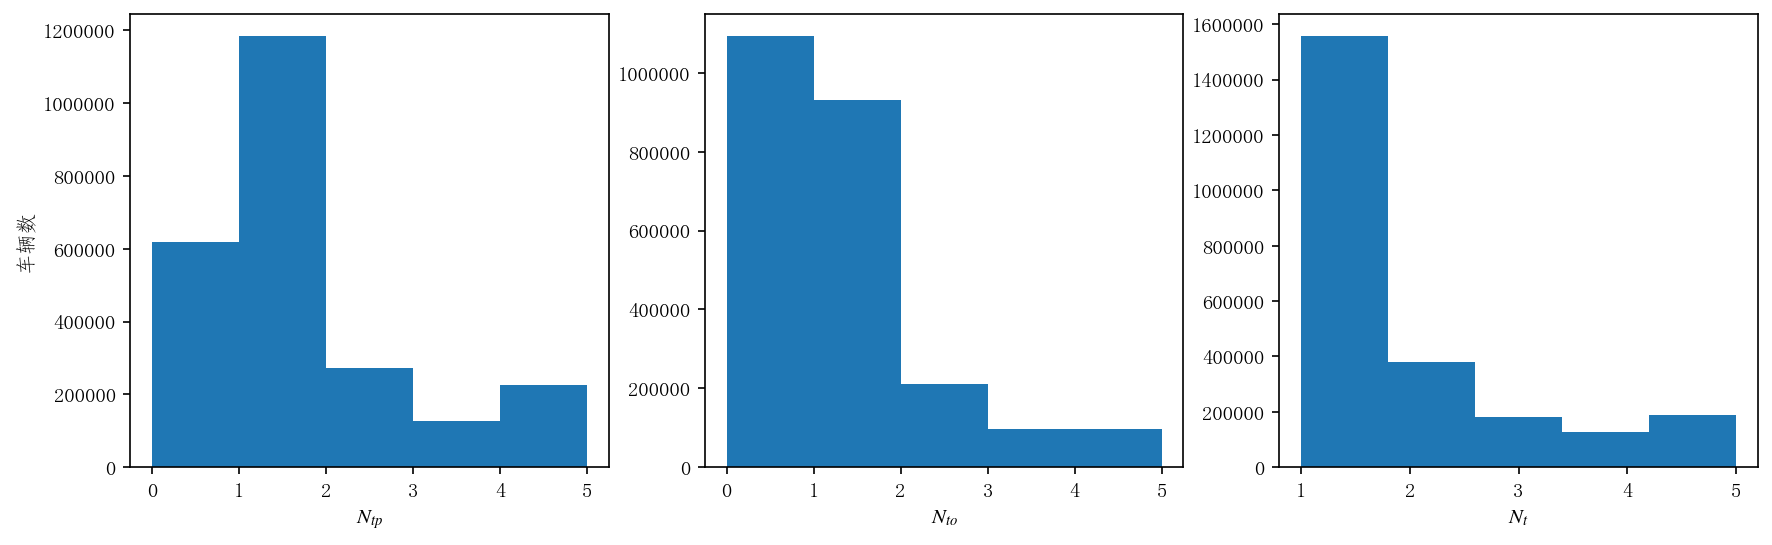

In [4]:
plt.rcParams['figure.dpi'] = 150 #分辨率
fig = plt.figure(figsize=(14,4))
ax1 = plt.subplot(131)
ax1.set_xlabel("$N_{tp}$")
ax1.set_ylabel("车辆数")
ax1.hist(df['traday_peak'],bins = 5)
ax2 = plt.subplot(132)
ax2.hist(df['traday_nonpeak'],bins=5)
ax2.set_xlabel("$N_{to}$")
ax3 = plt.subplot(133)
ax3.hist(df['traday'],bins=5)
ax3.set_xlabel("$N_{t}$")

In [6]:
# 将出行只有一天的车辆去除
df_tem=df[df['traday'] == 1]
df_other=df[df['traday'] > 1]
print(len(df_tem),len(df_other))

1558287 872028


Text(0.5, 0, '$F_{t}$')

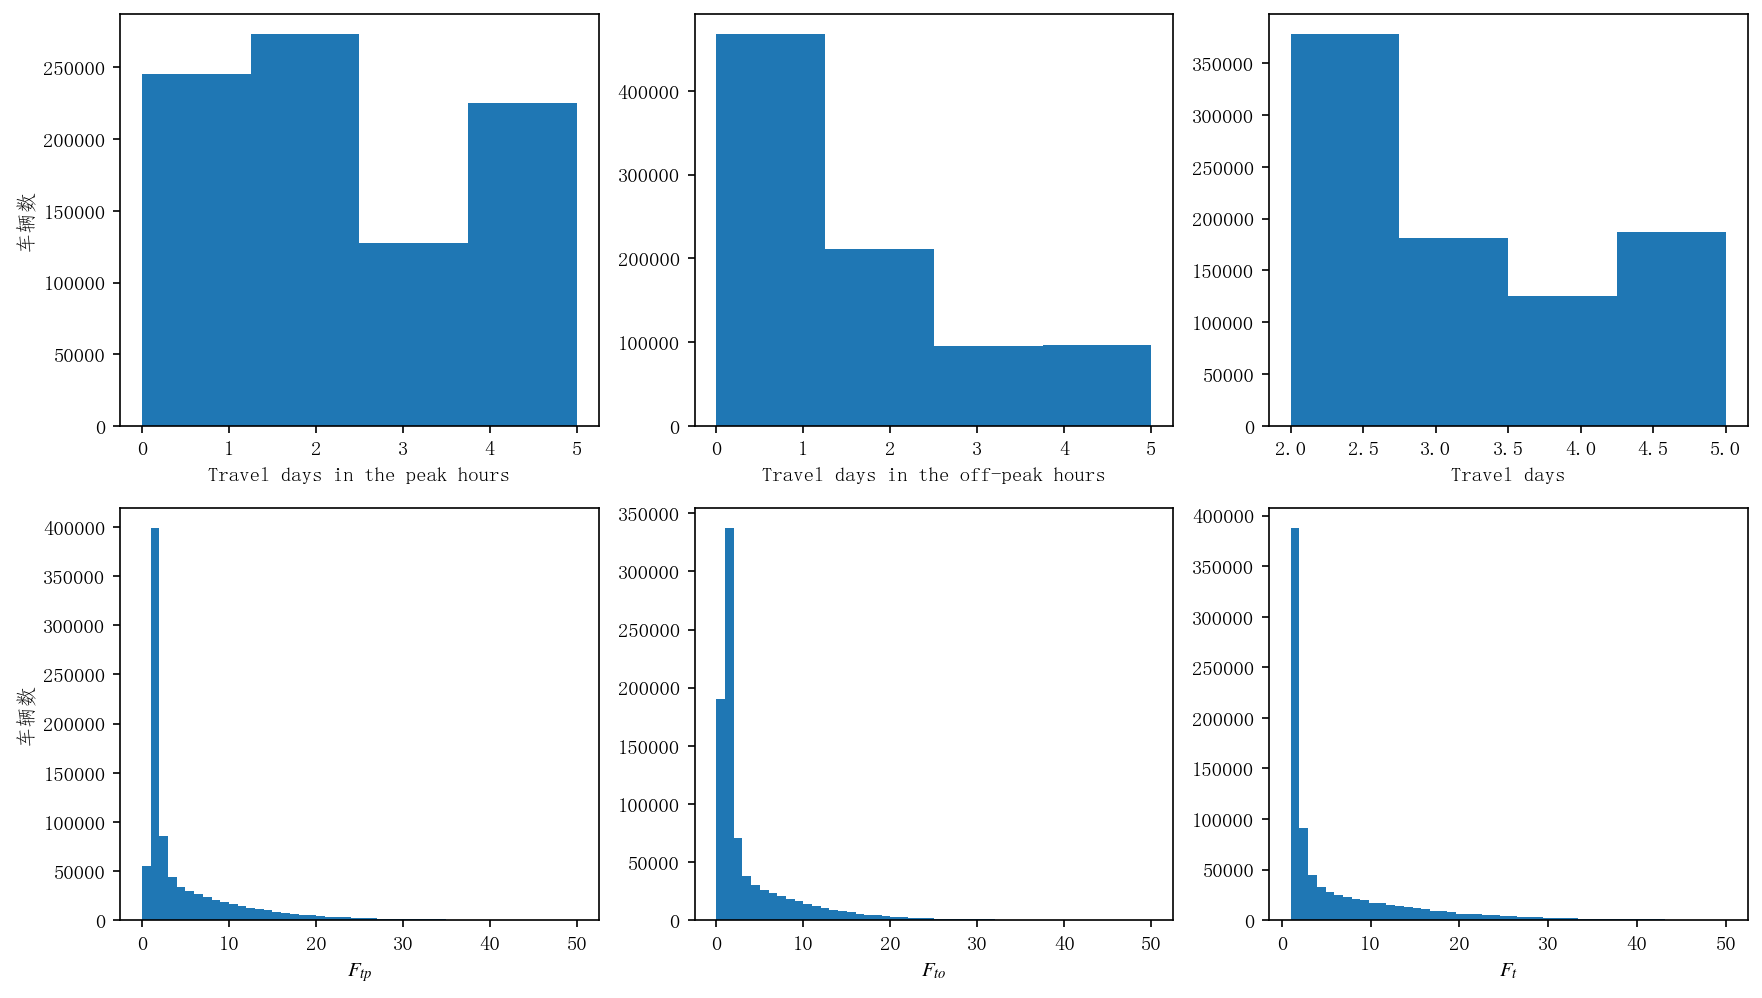

In [8]:
plt.rcParams['figure.dpi'] = 150 #分辨率
fig = plt.figure(figsize=(14,8))
ax1 = plt.subplot(231)
ax1.set_xlabel("Travel days in the peak hours")
ax1.set_ylabel("车辆数")
ax1.hist(df_other['traday_peak'],bins = 4)
ax2 = plt.subplot(232)
ax2.hist(df_other['traday_nonpeak'],bins=4)
ax2.set_xlabel("Travel days in the off-peak hours")
ax3 = plt.subplot(233)
ax3.hist(df_other['traday'],bins=4)
ax3.set_xlabel("Travel days")
ax4 = plt.subplot(234)
ax4.hist(df_other[df_other['fre_peak'] <= 50]['fre_peak'],bins=50)
ax4.set_xlabel("$F_{tp}$")
ax4.set_ylabel("车辆数")
ax5 = plt.subplot(235)
ax5.hist(df_other[df_other['fre_nonpeak'] <= 50]['fre_nonpeak'],bins=50)
ax5.set_xlabel("$F_{to}$")
ax6 = plt.subplot(236)
ax6.hist(df_other[df_other['fre_avg'] <= 50]['fre_avg'],bins=50)
ax6.set_xlabel("$F_{t}$")

In [11]:
# 将仅仅给检测到1-2次的车辆去除，这部分车辆往往是过境车辆
df_transit = df_other[df_other['fre_avg']<=2]
df_ana = df_other[df_other['fre_avg']>2]
print(len(df_transit),len(df_ana))

430840 441188


Text(0.5, 0, 'Detected times')

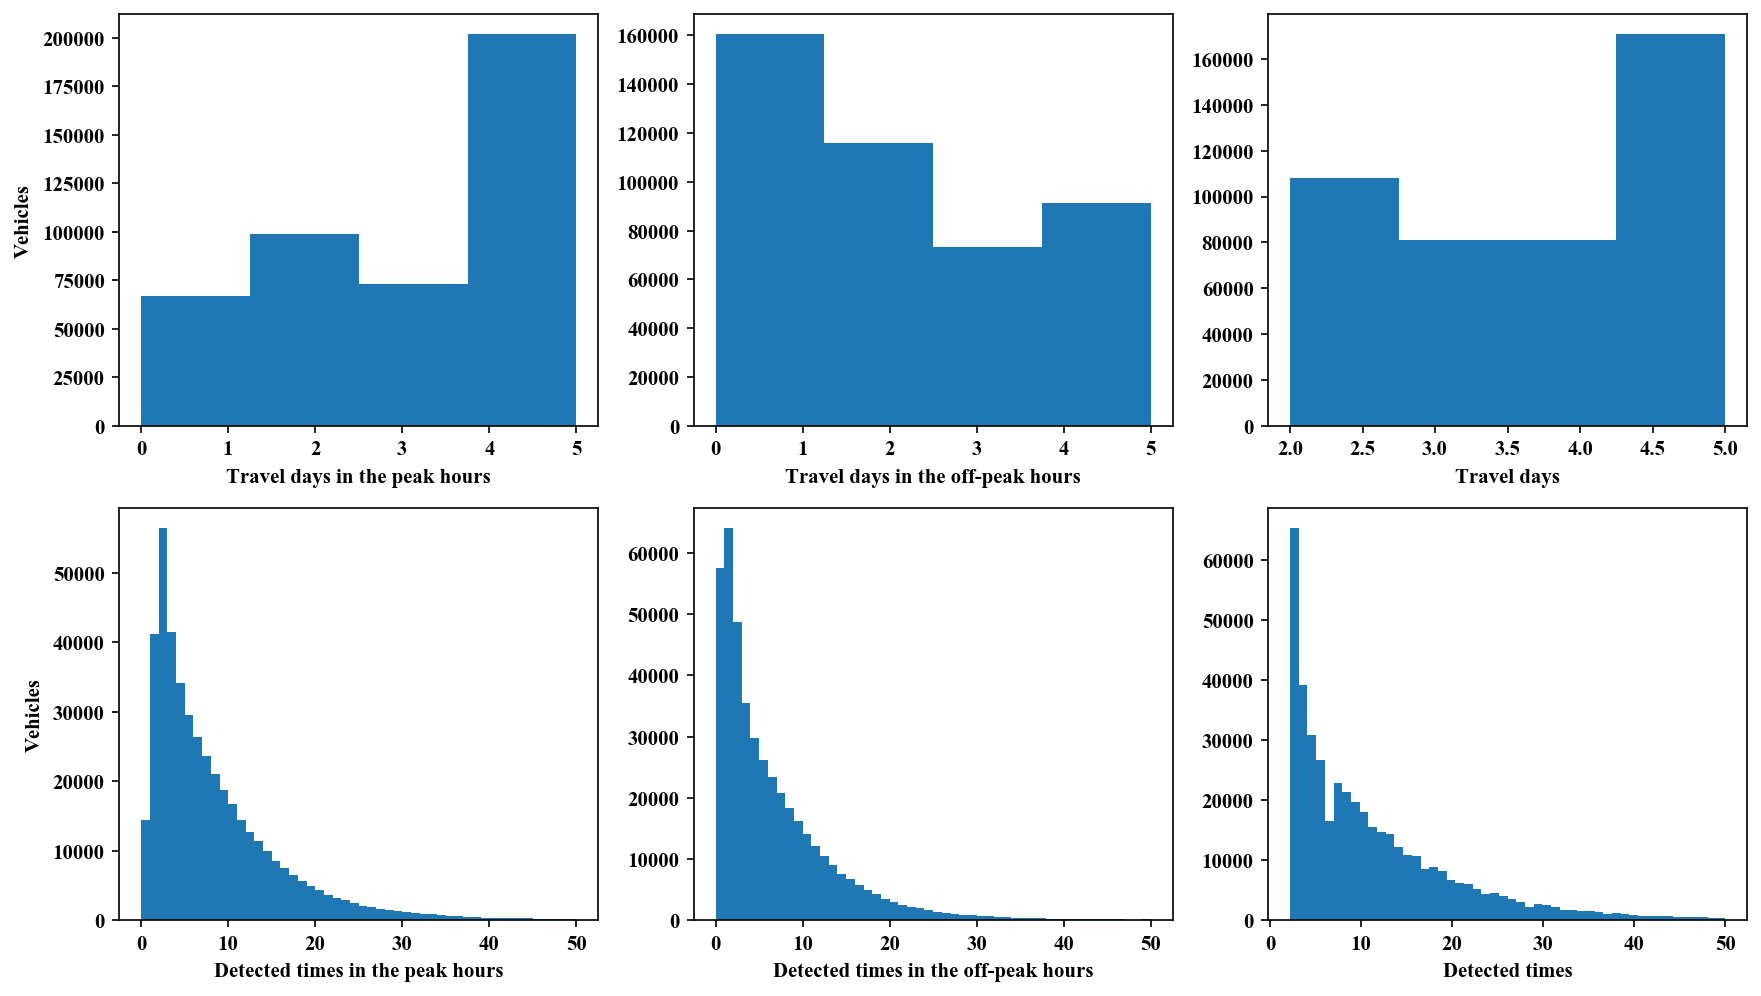

In [18]:
plt.rcParams['figure.dpi'] = 150 #分辨率
fig = plt.figure(figsize=(14,8))
ax1 = plt.subplot(231)
ax1.set_xlabel("Travel days in the peak hours")
ax1.set_ylabel("Vehicles")
ax1.hist(df_ana['traday_peak'],bins = 4)
ax2 = plt.subplot(232)
ax2.hist(df_ana['traday_nonpeak'],bins=4)
ax2.set_xlabel("Travel days in the off-peak hours")
ax3 = plt.subplot(233)
ax3.hist(df_ana['traday'],bins=4)
ax3.set_xlabel("Travel days")
ax4 = plt.subplot(234)
ax4.hist(df_ana[df_ana['fre_peak'] <= 50]['fre_peak'],bins=50)
ax4.set_xlabel("Detected times in the peak hours")
ax4.set_ylabel("Vehicles")
ax5 = plt.subplot(235)
ax5.hist(df_ana[df_ana['fre_nonpeak'] <= 50]['fre_nonpeak'],bins=50)
ax5.set_xlabel("Detected times in the off-peak hours")
ax6 = plt.subplot(236)
ax6.hist(df_ana[df_ana['fre_avg'] <= 50]['fre_avg'],bins=50)
ax6.set_xlabel("Detected times")

# 3.聚类分析
## 3.1确定最优聚类数目
由于总样本量较大，共包含279973辆车，因此确定聚类数目的时候不使用整个样本，以10%抽样率进行随机抽样，然后利用敏感性分析确定最优初始聚类数目。

In [12]:
# 归一化处理
# 对拓扑重要性和实际重要性都进行归一化处理
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
df_sample = df_ana.sample(frac=0.1,axis=0,random_state=0)
# 对数据进行min max标准化
scaler = preprocessing.StandardScaler()
data = scaler.fit_transform(df_sample[['fre_peak','fre_nonpeak','traday_peak','traday_nonpeak','traday','fre_avg']].values)
data

array([[-0.62662672, -0.51761603, -1.45297613, -0.11809905, -0.58919283,
        -0.73881218],
       [-0.78880105, -0.66103545,  1.19961542,  1.91854409,  1.06540749,
        -0.71279947],
       [-0.25594253,  0.19948104,  1.19961542, -0.7969801 ,  1.06540749,
        -0.33821642],
       ...,
       [ 0.55492913, -0.84356925,  1.19961542, -1.47586115,  1.06540749,
         0.0831895 ],
       [-0.82934463, -0.615402  ,  0.53646754,  1.23966304,  1.06540749,
        -0.75962235],
       [-0.25015059, -0.45242539,  0.53646754, -0.7969801 ,  1.06540749,
        -0.50990032]])

E:\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:788: FutureWarning: 'precompute_distances' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25). It has no effect
  ". It has no effect", FutureWarning)
E:\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


2 clustering method has been successfully run


E:\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:788: FutureWarning: 'precompute_distances' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25). It has no effect
  ". It has no effect", FutureWarning)
E:\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


3 clustering method has been successfully run


E:\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:788: FutureWarning: 'precompute_distances' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25). It has no effect
  ". It has no effect", FutureWarning)
E:\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


4 clustering method has been successfully run


E:\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:788: FutureWarning: 'precompute_distances' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25). It has no effect
  ". It has no effect", FutureWarning)
E:\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


5 clustering method has been successfully run


E:\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:788: FutureWarning: 'precompute_distances' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25). It has no effect
  ". It has no effect", FutureWarning)
E:\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


6 clustering method has been successfully run


E:\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:788: FutureWarning: 'precompute_distances' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25). It has no effect
  ". It has no effect", FutureWarning)
E:\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


7 clustering method has been successfully run


E:\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:788: FutureWarning: 'precompute_distances' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25). It has no effect
  ". It has no effect", FutureWarning)
E:\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


8 clustering method has been successfully run


E:\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:788: FutureWarning: 'precompute_distances' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25). It has no effect
  ". It has no effect", FutureWarning)
E:\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


9 clustering method has been successfully run


E:\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:788: FutureWarning: 'precompute_distances' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25). It has no effect
  ". It has no effect", FutureWarning)
E:\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


10 clustering method has been successfully run


E:\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:788: FutureWarning: 'precompute_distances' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25). It has no effect
  ". It has no effect", FutureWarning)
E:\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


11 clustering method has been successfully run


E:\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:788: FutureWarning: 'precompute_distances' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25). It has no effect
  ". It has no effect", FutureWarning)
E:\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


12 clustering method has been successfully run


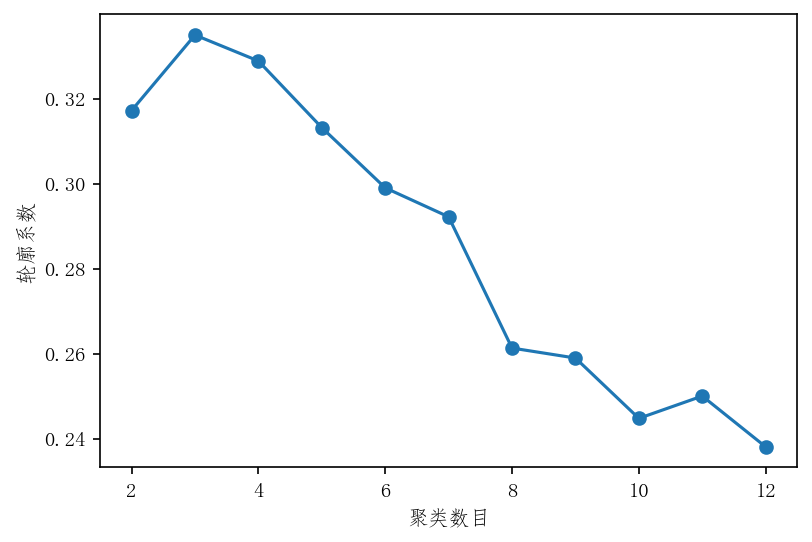

In [13]:
plt.rcParams['figure.dpi'] = 150 #分辨率
Scores = [] # 存储不同初始聚类数目的轮廓系数值
for k in range(2,13):  
    estimator = KMeans(n_clusters=k,init='k-means++', n_init=10, max_iter=300, tol=0.0001, 
                       precompute_distances='auto', verbose=0, random_state=0, copy_x=True, n_jobs=-1, 
                       algorithm='auto')  # 构造聚类器  
    labels = estimator.fit_predict(data)  
    Scores.append(silhouette_score(data , labels , random_state=0))  
    print("{0} clustering method has been successfully run".format(k))
X = range(2,13)  
plt.xlabel('聚类数目')  
plt.ylabel('轮廓系数')  
plt.plot(X,Scores,'o-')  
plt.show()  

## 3.2聚类分析，进而分析各个簇的出行行为

In [23]:
# 将整个数据集标准化
scaler = preprocessing.StandardScaler()
data = scaler.fit_transform(df_ana[['fre_peak','fre_nonpeak','traday_peak','traday_nonpeak','traday','fre_avg']].values)
# 聚类成3个簇看一下结果
estimator = KMeans(n_clusters=3,init='k-means++', n_init=10, max_iter=300, tol=0.0001, 
                       precompute_distances='auto', verbose=0, random_state=0, copy_x=True, n_jobs=-1, 
                       algorithm='auto')  # 构造聚类器
labels = estimator.fit_predict(data)
print(silhouette_score(data , labels , random_state=0))
df_ana['labels'] = labels
df_ana.head(2)

E:\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:788: FutureWarning: 'precompute_distances' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25). It has no effect
  ". It has no effect", FutureWarning)
E:\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


0.3355986372522594


E:\Anaconda\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


,car_num,peak0318,nonpeak0318,peak0319,nonpeak0319,peak0320,nonpeak0320,peak0321,nonpeak0321,peak0322,nonpeak0322,feats,fre_peak,fre_nonpeak,traday_peak,traday_nonpeak,traday,fre_avg,labels
3,云A114QQ,2.0,27.0,3.0,7.0,9.0,9.0,13.0,33.0,5.0,6.0,"(6.4, 16.4, 5, 5, 5, 22.8)",6.4,16.40,5,5,5,22.8,1
6,云A1J1J9,6.0,17.0,3.0,0.0,0.0,4.0,0.0,1.0,0.0,1.0,"(4.5, 5.75, 2, 4, 5, 6.4)",4.5,5.75,2,4,5,6.4,1


In [25]:
# 将各种结果都保存下
path = './数据/车辆画像结果/'
df_tem.to_csv(path+"临时办事车辆.csv",index=False,encoding='gbk')  # 一周内仅仅出现一天的车辆
df_transit.to_csv(path+'频繁过境车辆.csv',index=False,encoding='gbk') # 一周出现大于一天，日均被检测频次小于等于2次的车辆
df_ana.to_csv(path+"聚类画像结果.csv",index=False,encoding='gbk') # 聚类画像结果

In [26]:
for i in range(3):
    print(df_ana[df_ana['labels'] == i][['fre_peak','fre_nonpeak','traday_peak','traday_nonpeak','traday','fre_avg']].describe())

            fre_peak    fre_nonpeak    traday_peak  traday_nonpeak  \
count  193826.000000  193826.000000  193826.000000   193826.000000   
mean        5.790429       5.549788       1.796565        1.530785   
std         5.270249       5.697408       0.848259        0.971135   
min         0.000000       0.000000       0.000000        0.000000   
25%         2.000000       1.333333       1.000000        1.000000   
50%         4.000000       4.000000       2.000000        2.000000   
75%         8.000000       8.000000       2.000000        2.000000   
max        46.000000      51.000000       3.000000        5.000000   

              traday        fre_avg  
count  193826.000000  193826.000000  
mean        2.512336       8.567697  
std         0.616966       6.053068  
min         2.000000       2.200000  
25%         2.000000       3.666667  
50%         2.000000       6.666667  
75%         3.000000      11.666667  
max         5.000000      41.500000  
           fre_peak    fre_